# Scene Classification

## Overview
1. Preprocess
    - Import pkg
    - Import data
    - Show a sample
    - Shuffle split data
2. Analysis Features
3. Build Model
4. Train & Cross Validation
5. Predict

Reference:
- https://challenger.ai/competitions
- https://github.com/jupyter/notebook/issues/2287

## 1. Preprocess

Import pkg

In [1]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [3]:
# import zipfile
import os
import zipfile
import math
from time import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

### Import data
Need extract zip file manully.

In [4]:
input_path = './input'
zip_path = input_path + '/ai_challenger_scene_train_20170904.zip'
extract_path = input_path + '/ai_challenger_scene_train_20170904'

image_path = extract_path + '/scene_train_images_20170904'
scene_classes_path = extract_path + '/scene_classes.csv'
scene_train_annotations_path = extract_path + '/scene_train_annotations_20170904.json'

In [5]:
input_file = './input/ai_challenger_scene_train_20170904.zip'
if not os.path.isdir(extract_path):
    with zipfile.ZipFile(zip_path) as file:
        for name in file.namelist():
            file.extract(name, input_path)

Import "scene_classes.csv"

In [6]:
scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


import "scene_train_annotations_20170904.json"

**This part need jupyter notebook start with "jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000000"**
https://github.com/jupyter/notebook/issues/2287

In [7]:
with open(scene_train_annotations_path, 'r', encoding='utf-8') as file:
    content = ''
    for line in file:
        content = content + line
scene_train_annotations = json.loads(content)

In [8]:
#We get a list
print('scene_train_annotations.type: %s' %type(scene_train_annotations))
print('scene_train_annotations.shape: %s' %len(scene_train_annotations))
order = 0
print(scene_train_annotations[order])
print('label_id[%s]:\t%s' %(order, scene_train_annotations[order]['label_id']))
print('image_id[%s]:\t%s' %(order, scene_train_annotations[order]['image_id']))

scene_train_annotations.type: <class 'list'>
scene_train_annotations.shape: 53879
{'image_id': '79f993ae0858ae238b22968c5934d1ddba585ae4.jpg', 'label_id': '66', 'image_url': 'https://n1-q.mafengwo.net/s1/M00/6B/72/wKgBm04Wc5WzFXU0AAHf09bdpiY84.jpeg?imageView2%2F2%2Fw%2F600%2Fq%2F90'}
label_id[0]:	66
image_id[0]:	79f993ae0858ae238b22968c5934d1ddba585ae4.jpg


Test the image and pickle function

Data save into pickle file:
[ 66.  61.]
(2, 224, 224, 3)
Load data from pickle file:
[ 66.  61.]
(2, 224, 224, 3)


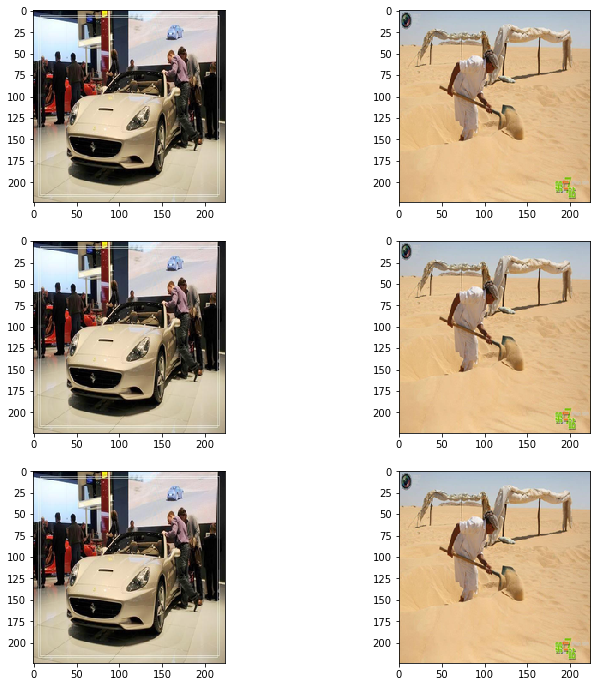

In [9]:
# length = len(scene_train_annotations)
length = 2
box = (224, 224)
x_shape = [length, box[0], box[1], 3]
x_data = np.zeros(x_shape)
y_data = np.zeros(length)

fig, ax = plt.subplots(3, length, figsize=(12, 12))

for i in range(length):
    y_data[i] = scene_train_annotations[i]['label_id']
    path = image_path + '/' + scene_train_annotations[i]['image_id']
    img = Image.open(path)
    img1 = img.resize(box, Image.ANTIALIAS) # resizes image in-place
    imgData = np.asarray(img1)
    ax[0][i].imshow(imgData)
    imgData = imgData.astype("float32")
    imgData = imgData/255.0
    ax[1][i].imshow(imgData)
    x_data[i] = imgData
    ax[2][i].imshow(x_data[i])

print('Data save into pickle file:')
print(y_data)
print(x_data.shape)
# print(x_data[0])

pickle_path = input_path + '/pickle'
if not os.path.isdir(pickle_path):
    os.mkdir(pickle_path)
    
x_data_path = input_path + '/pickle/x_data_sample.p'
y_data_path = input_path + '/pickle/y_data_sample.p'

pickle.dump(x_data, open(x_data_path, 'wb'))
pickle.dump(y_data, open(y_data_path, 'wb'))

x_data = pickle.load(open(x_data_path, mode='rb'))
y_data = pickle.load(open(y_data_path, mode='rb'))
print('Load data from pickle file:')
print(y_data)
print(x_data.shape)

Convert data into numpy.array and part data into serval pickle file

In [10]:
def convert_and_save_data(partNum, partLen):
    x_shape = [partLen, box[0], box[1], 3]
    x_data = np.zeros(x_shape)
    y_data = np.zeros(partLen)

    # fig, ax = plt.subplots(3, length, figsize=(12, 12))

    for i in range(partLen):
        y_data[i] = scene_train_annotations[i]['label_id']
        path = image_path + '/' + scene_train_annotations[i]['image_id']
        img = Image.open(path)
        img1 = img.resize(box, Image.ANTIALIAS) # resizes image in-place
        imgData = np.asarray(img1)
    #     ax[0][i].imshow(imgData)
        imgData = imgData.astype("float32")
        imgData = imgData/255.0
    #     ax[1][i].imshow(imgData)
        x_data[i] = imgData
    #     ax[2][i].imshow(x_data[i])

    print('Data save into pickle file:')
    print(y_data.shape)
    print(x_data.shape)
    # print(x_data[0])
    
    pickle_path = input_path + '/pickle'
    if not os.path.isdir(pickle_path):
        os.mkdir(pickle_path)
    
    x_data_path = pickle_path + '/x_data' + str(partNum) + '.p'
    y_data_path = pickle_path + '/y_data' + str(partNum) + '.p'

    pickle.dump(x_data, open(x_data_path, 'wb'))
    pickle.dump(y_data, open(y_data_path, 'wb'))

    x_data = pickle.load(open(x_data_path, mode='rb'))
    y_data = pickle.load(open(y_data_path, mode='rb'))
    print('Load data from pickle file:')
    print(y_data.shape)
    print(x_data.shape)

In [11]:
length = len(scene_train_annotations)
# length = 25
partLen = 1000
partAmount = math.ceil(length/partLen)
print('data length:\t%s' %length)
print('partSize:\t%s' %partLen)
print('partAmount:\t%s' %partAmount)

box = (224, 224)
print('image box:\t%sx%s' %box)

for i in range(partAmount):
    remainder = length - i*partLen
    if remainder < partLen:
        thisPartLen = remainder
    else:
        thisPartLen = partLen
#     x_shape = [thisPartLen, box[0], box[1], 3]
#     x_data = np.zeros(x_shape)
#     y_data = np.zeros(thisPartLen)

    print('thisPartLen %s:\t%s\t' %(i, thisPartLen))
    convert_and_save_data(i, thisPartLen)

data length:	53879
partSize:	1000
partAmount:	54
image box:	224x224
thisPartLen 0:	1000	
Data save into pickle file:
(1000,)
(1000, 224, 224, 3)
Load data from pickle file:
(1000,)
(1000, 224, 224, 3)
thisPartLen 1:	1000	
Data save into pickle file:
(1000,)
(1000, 224, 224, 3)
Load data from pickle file:
(1000,)
(1000, 224, 224, 3)
thisPartLen 2:	1000	
Data save into pickle file:
(1000,)
(1000, 224, 224, 3)
Load data from pickle file:
(1000,)
(1000, 224, 224, 3)
thisPartLen 3:	1000	
Data save into pickle file:
(1000,)
(1000, 224, 224, 3)
Load data from pickle file:
(1000,)
(1000, 224, 224, 3)
thisPartLen 4:	1000	
Data save into pickle file:
(1000,)
(1000, 224, 224, 3)
Load data from pickle file:
(1000,)
(1000, 224, 224, 3)
thisPartLen 5:	1000	
Data save into pickle file:
(1000,)
(1000, 224, 224, 3)
Load data from pickle file:
(1000,)
(1000, 224, 224, 3)
thisPartLen 6:	1000	
Data save into pickle file:
(1000,)
(1000, 224, 224, 3)
Load data from pickle file:
(1000,)
(1000, 224, 224, 3)
t

In [12]:
print('Done!')

Done!
